In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import graphviz

In [2]:
# a scalar valued function in python takes in scalar x and returns scalar y 
def function(x):
    return 4*x**2+8*x+4
# derivative of this function is 8*x+8

In [3]:
function(3.0)

64.0

In [4]:
xs = np.arange (-5,5,0.20)
xs

array([-5.0000000e+00, -4.8000000e+00, -4.6000000e+00, -4.4000000e+00,
       -4.2000000e+00, -4.0000000e+00, -3.8000000e+00, -3.6000000e+00,
       -3.4000000e+00, -3.2000000e+00, -3.0000000e+00, -2.8000000e+00,
       -2.6000000e+00, -2.4000000e+00, -2.2000000e+00, -2.0000000e+00,
       -1.8000000e+00, -1.6000000e+00, -1.4000000e+00, -1.2000000e+00,
       -1.0000000e+00, -8.0000000e-01, -6.0000000e-01, -4.0000000e-01,
       -2.0000000e-01,  4.4408921e-15,  2.0000000e-01,  4.0000000e-01,
        6.0000000e-01,  8.0000000e-01,  1.0000000e+00,  1.2000000e+00,
        1.4000000e+00,  1.6000000e+00,  1.8000000e+00,  2.0000000e+00,
        2.2000000e+00,  2.4000000e+00,  2.6000000e+00,  2.8000000e+00,
        3.0000000e+00,  3.2000000e+00,  3.4000000e+00,  3.6000000e+00,
        3.8000000e+00,  4.0000000e+00,  4.2000000e+00,  4.4000000e+00,
        4.6000000e+00,  4.8000000e+00])

[ 64.    57.76  51.84  46.24  40.96  36.    31.36  27.04  23.04  19.36
  16.    12.96  10.24   7.84   5.76   4.     2.56   1.44   0.64   0.16
   0.     0.16   0.64   1.44   2.56   4.     5.76   7.84  10.24  12.96
  16.    19.36  23.04  27.04  31.36  36.    40.96  46.24  51.84  57.76
  64.    70.56  77.44  84.64  92.16 100.   108.16 116.64 125.44 134.56]


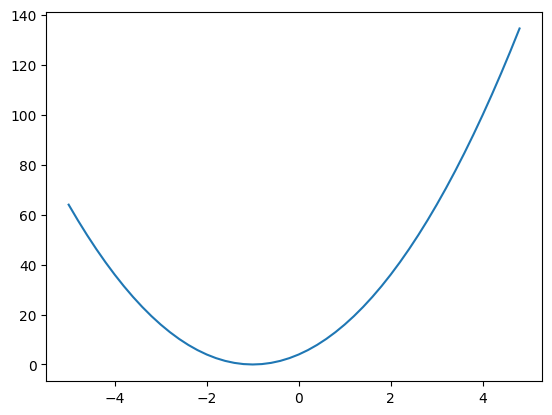

In [5]:
ys = function(xs)
print(ys)
plt.plot(xs,ys)

In [6]:
h = 0.000001
x = -1.0
function(x)
#the smaller the h the more we converge towards to actual derivative since h should tend to 0

0.0

In [7]:
function(x+h)

3.999911513119514e-12

In [8]:
#calculate slope from definition rise/run
y = (function(x+h) - function(x))/h

In [9]:
y
# if you plug in x = 2 into 8*x+8 you get 24 and here you see that the derivative is converging towards 24

3.999911513119514e-06

In [10]:
a=2.0
b=-3.0
c=4.0
d=a*b+c
# a function which accepts 3 scalars as input and gives 1 scalar as output

In [11]:
h=0.0001
a=2.0
b=-3.0
c=4.0
d1 = a*b+c
a += h
d2 = a*b+c
print(d1)
print(d2)
print(f"slope is",(d2-d1)/h)
#this is calculating dd/da (change in d wrt change in a) which if you calculate will be b itself
#b is -3 so the slope is also converging to -3

-2.0
-2.000300000000001
slope is -3.000000000010772


In [12]:
#neural nets are insanely large math expressions which you cannot hope to write out each step of 
#Besides we need to calculate gradients at each step and also have the computational history ready which scalars
#CANNOT do hence we need these objects (lets say value objects to wrap these scalars)
#These objects will help us keep track of computational history and calcualte gradient of loss function wrt itself

In [13]:
class Value:
    def __init__(self,data,_children=(),_op='',label =''):
        self.data = data
        self.grad = 0
        self._backward = lambda : None 
        # Setting _backward to lambda: None allows every Value node to 
        # safely have a backward function by default and lets you swap in the correct logic when you 
        # know what operation created the node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        other = other  if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1 * out.grad #accumultaing the gradients in case inputs repeats itself
            other.grad += 1 * out.grad
        out._backward = _backward
        # we are only assigning the function here and NOT calling hence no brackets
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __mul__(self,other):
        other = other  if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self,other):#fallback inbuilt in py that reverses the other to do 2*a since mul cant do that
        return self*other
        
    def __truediv__(self,other):
        other = other  if isinstance(other, Value) else Value(other)
        out = self*other**(-1.0)
        return out

    def tanh(self):
        n= self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        n= self.data
        out = Value(math.exp(n),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value (4.0,label='c')
e = a*b; e.label ='e'
f = Value(-3.0);f.label ='f'
d=e+c;d.label ='d'
L = d*f; L.label ='L'
#behind the scenes: 
# (a.__mul__(b)).__add__(c) -- you can call this as well (like normal function calling in python)
#TypeError: unsupported operand type(s) for +: 'Value' and 'Value'
#So it gives an error because we havent yet defined addition for the Value objects
#repr is for string representation of an object similar to how init is for initialising an object
#the double _ before and after denote that they are special functions understood by the python interpreter
#__truediv() for division in python 3, python 2 used __div__

#grad will calculate the derivative of output( L here ) wrt to the nodes ie wrt 

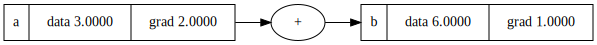

In [16]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


In [17]:
a=Value(2)
b=Value(5)
a/b


Value(data = 0.4)

In [18]:
#__add__ is a special (magic) method in Python that overloads the + operator.
#When you write a + b and a is an instance of your class, Python internally calls a.__add__(b).
#So defining __add__ lets you customize what + means for your objects. So for defining operators we need
#the double underscore
#cool, now we have the basic operations defined


In [19]:
 # Converting _children to a set ensures uniqueness and faster membership checks

 #    > Uniqueness: Sets automatically eliminate duplicate entries. 
 #    In computational graphs, each parent Value should only appear once in _prev to avoid redundant
 #    processing during backward passes.

 #    > Fast Lookup: Checking if an element exists in a set uses hash-based lookup with average O(1) time,
 #    faster than lists which have O(n) lookup time. This speeds up traversing or updating the graph.

 # basically to make the computational history thing more efficient


In [20]:
d

Value(data = -2.0)

In [21]:
d._op

'+'

In [22]:
d._prev

{Value(data = -6.0), Value(data = 4.0)}

In [23]:
d.label

'd'

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % ( n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

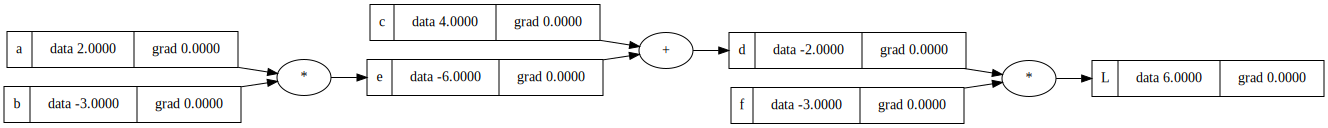

In [25]:
draw_dot(L)

In [26]:
def lol():
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value (4.0,label='c')
    e = a*b; e.label ='e'
    f = Value(-3.0);f.label ='f'
    d=e+c;d.label ='d'
    L = d*f; L.label ='L'
    L1 = L.data

    
    h=0.0001
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    b.data +=h
    c = Value (4.0,label='c')
    e = a*b; e.label ='e'
    f = Value(-3.0);f.label ='f'
    d=e+c;d.label ='d'
    L = d*f; L.label ='L'
    L2 = L.data

    print((L2-L1)/h)

lol()
# in this the scope of the variables is within the function lol so the global vars are not affected
#basically the expression for L is abf + cf so if we diff wrt a bf will remain b*f =9 

-6.000000000012662


In [27]:
L.tanh()

Value(data = 0.9999877116507956)

In [28]:
L.grad = 1.0
f.grad = -2.0
d.grad = -3.0
e.grad = -3.0
c.grad = -3.0
a.grad = 9.0
b.grad = -6.0

In [29]:
# dL/de = -3.0
# we want dL/da and dL/db for which we need de/da and de/db which are d and a resp
# dL/da = dL/de * de/da = -3.0 * -3.0 = 9.0

<function matplotlib.pyplot.show(close=None, block=None)>

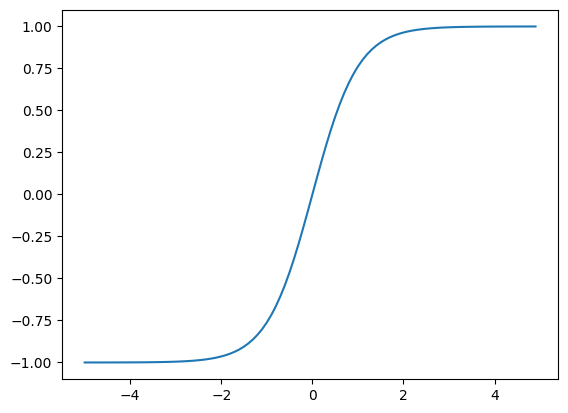

In [30]:
plt.plot(np.arange(-5,5,0.1),np.tanh(np.arange(-5,5,0.1)))
plt.show
#basically squishes the input like sigmoid or relu

In [31]:
#inputs x1 and x2 these are fixed so they do not change after each pass of back propagation
x1 = Value(2.0);x1.label = 'x1'
x2 = Value(-3.0);x2.label = 'x2'

#these are the weights w1,w2, these are changed based on the loss function value ; 
#changed against the direction of the gradient 
w1 = Value(4.0);w1.label = 'w1'
w2 = Value(-2.0);w2.label = 'w2'

#b is the bias
b = Value(-13.5,label ='b')
x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b ; n.label ='n'
o = n.tanh(); o.label = 'o'

In [32]:

o.backward()

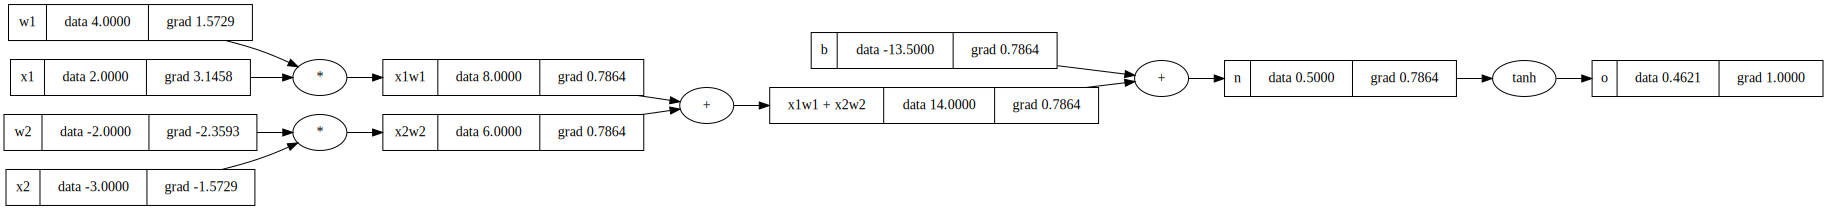

In [33]:
draw_dot(o)

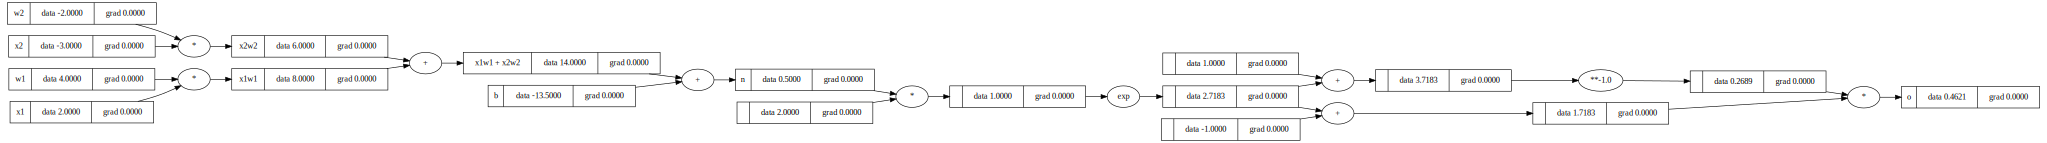

In [34]:
#inputs x1 and x2 these are fixed so they do not change after each pass of back propagation
x1 = Value(2.0);x1.label = 'x1'
x2 = Value(-3.0);x2.label = 'x2'

#these are the weights w1,w2, these are changed based on the loss function value ; 
#changed against the direction of the gradient 
w1 = Value(4.0);w1.label = 'w1'
w2 = Value(-2.0);w2.label = 'w2'

#b is the bias
b = Value(-13.5,label ='b')
x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b ; n.label ='n'

e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
draw_dot(o)

In [35]:
o.grad = 1
n.grad = 0.78646359
b.grad = x1w1x2w2.grad = x2w2.grad = x1w1.grad =0.78646359
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
#everything before this will be 0 so we need to adjust o
#for + operation gradient is simply distributed
# eg m1 = m2+ m3
#dm4/dm1 = k
#dm4/dm2 = dm4/dm1 *dm1/dm2 = k * 1 = k

# eg m1 = m2*m3
# dm4/dm1 = k
# dm4/dm2 = dm4/dm1 * dm1/dm2 = k * m3 (ie the other term)
# we actually are concerned with w1.grad and w2.grad
# for multiplication we get the other term * prev grad ( of product)
# here we also see that grad for w1 is 0 since x1 itslef is zero 
# so it is not affecting the final answer which is o

In [36]:
# we know o is tanh(n)
# do/dn = 1 - tanh(n)**2 = 1-o**2
# why is Relu used in place of tanh for activation ( 3 reasons) in case of neural networks


# ReLU keeps the gradient nonzero for positive inputs, helping weights update effectively 
# even in deep networks. Tanh (and sigmoid) can cause gradients to shrink towards zero for
# large/small inputs, slowing or stopping learning in deep layers.


#ReLU is faster to compute (just a comparison and a max operation), while tanh requires 
#exponentiation/division.

#ReLU outputs zero for negative values, which can introduce sparsity and better generalization.


In [37]:
1-(0.4621)**2

0.78646359

In [38]:
#now we have _backward() defined we have to call it in the right order right to left
o.grad = 1
o._backward()

In [39]:
n._backward()
b._backward() #leaf node so doesnt have a backward
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [40]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

In [41]:
o.backward()

In [42]:
import torch

In [43]:
a = torch.Tensor([[2,3,4],[4,5,6]])

In [44]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([-3.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([4.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([-2.0]).double()  ; w2.requires_grad = True
b = torch.Tensor([-13.5]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# our micrograd is based on scalars but pytorch uses tensors
# tensor is a n dim arrays of scalars
# we have used a scalar valued tensor here
# we get the same values as from our micrograd (Value class)
# we have type casted the values to double so that they are float64 which is default in python
# float32 is deafult in pytorch to save memory
# requires_grad is false bby default to save memory since leaf nodes do not require gradients
# we have implemented the same thing in pytorch here one neuron with 2 inputs and tanh as the activation function

0.46211715726000974
---
x2 -1.5728954659318548
w2 -2.359343198897782
x1 3.1457909318637096
w1 1.5728954659318548


/home/avinab/miniconda3/lib/python3.13/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [45]:
o

tensor([0.4621], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [46]:
o.data

tensor([0.4621], dtype=torch.float64)

In [47]:
o.data.item()

0.46211715726000974

In [48]:
#pytorch basics
t1 = torch.Tensor([2.0]).double()
t1.requires_grad = True
t2 = torch.Tensor([-4.0])
t2.requires_grad = True
t3 = t1*t2 + t1**2

In [49]:
t3.backward()

In [50]:
t1.grad.item()
t1.dtype

torch.float64

In [51]:
t2.dtype

torch.float32

In [52]:
print(f"gradient of t3 wrt t1 is", {t1.grad.item()})

gradient of t3 wrt t1 is {0.0}


In [53]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())


False
1


In [54]:
print(torch.__version__)

2.8.0+cu128


In [55]:
import random

In [88]:
class Neuron:

    def __init__(self,nin):#nin is number of inputs to the neuron will need same number of w's
        self.w = [Value(random.uniform(-1,1))for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) 
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

        
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
      
x = [2]
n = MLP(2,[2,3,1])
n(x) # __call__ lets you use neuron objects like functions.

# for sum function the generator expression needs to be in brackets and the first value should be in same type

Value(data = 0.5232428178844298)

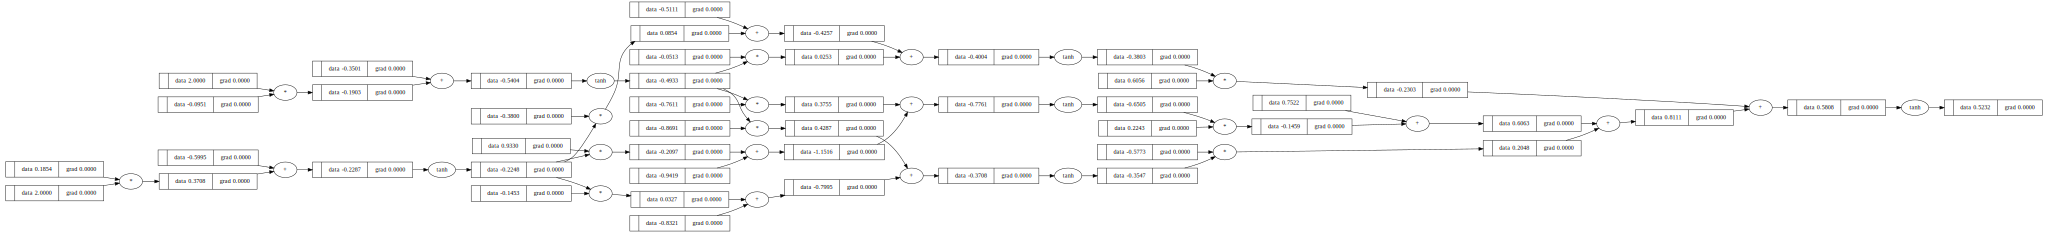

In [89]:
draw_dot(n(x))

In [90]:
xs = [[2,3,4],[1,2,3],[3,-2,3],[1,1,1]]
ys = [1,-1,-1,1]

In [91]:
ypred = [n(x) for x in xs]

In [92]:
ypred # stands for y predicted

[Value(data = 0.5916729122342286),
 Value(data = 0.5925694168997591),
 Value(data = 0.49327270204350654),
 Value(data = 0.56768505602761)]

In [93]:
loss = sum(((yout-ygt)**2 for ygt,yout in zip(ys,ypred)), Value(0))
loss
# we want the loss to be lower
loss.backward()

In [94]:
n.layers[0].neurons[0].w[0].data

0.18540273000669805

In [95]:
for p in n.parameters():
    p.data += -0.001* p.grad

In [96]:
n.layers[0].neurons[0].w[0].data

0.18477813125279072

In [97]:
ypred

[Value(data = 0.5916729122342286),
 Value(data = 0.5925694168997591),
 Value(data = 0.49327270204350654),
 Value(data = 0.56768505602761)]

In [98]:
ys

[1, -1, -1, 1]

In [99]:
loss

Value(data = 5.11976793169788)

In [100]:
n.parameters() 

[Value(data = 0.18477813125279072),
 Value(data = -0.10298322055923356),
 Value(data = -0.5996501321021412),
 Value(data = -0.09628564608324403),
 Value(data = 0.10976034235658544),
 Value(data = -0.3507343554850768),
 Value(data = 0.9329232496580281),
 Value(data = -0.7608005149550779),
 Value(data = -0.9423674343622487),
 Value(data = -0.1453323952104651),
 Value(data = -0.8699711981082802),
 Value(data = -0.8305072064681179),
 Value(data = -0.3798527434029518),
 Value(data = -0.05045871144770844),
 Value(data = -0.5126662485272448),
 Value(data = 0.22571366146654662),
 Value(data = -0.5762596827258367),
 Value(data = 0.6069858773948131),
 Value(data = 0.7490228892433763)]

In [101]:
for k in range(90):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # this is zerograd basically grad is reset to 0 at the start of a pass
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data)

0 5.0950228471275185
1 4.047345304038843
2 3.7221857423182083
3 3.5493380607704728
4 3.406285781634759
5 3.301037311242715
6 3.2254064515454752
7 3.1695497197469447
8 3.126200098403374
9 3.0906391883870334
10 3.060017703100258
11 3.0327016160380493
12 3.0077942417986585
13 2.984822183177332
14 2.963538414550804
15 2.9438040208455707
16 2.925522341240467
17 2.908606835274005
18 2.89296881218069
19 2.878515306221667
20 2.8651510822670185
21 2.852781594087989
22 2.8413155300550508
23 2.8306665513244518
24 2.8207542572390447
25 2.8115045538306207
26 2.8028496131444456
27 2.7947275771937905
28 2.787082118224083
29 2.77986193049985
30 2.773020201319315
31 2.766514089682796
32 2.7603042281528265
33 2.7543542551262408
34 2.748630379533024
35 2.743100976818834
36 2.7377362132192102
37 2.7325076942964595
38 2.727388133157367
39 2.722351033487444
40 2.7173703823870388
41 2.712420347886567
42 2.707474975893448
43 2.7025078811421945
44 2.697491926453091
45 2.6923988842318276
46 2.687199073643088
47

In [102]:
ypred

[Value(data = 0.5633477086886985),
 Value(data = -0.388120563185555),
 Value(data = -0.7846936122802993),
 Value(data = 0.6491296021012662)]

In [104]:
len(n.parameters())# very small network, gpt has billions of parameters for eg

19